In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

import pandas as pd
from laspy.file import File
from pickle import dump, load

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as udata
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import lidar_data_processing

%matplotlib inline

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data' # not used
        self.dataset= 'masked_pwc' # move lidar into datasets
        self.batch_size= 64
        self.model= 'lidar_unet2d'
        self.in_channels = 6
        self.lr= 0.005
        self.weight_decay = 0.
        self.num_epochs= 5
        self.min_sep = 5 # not used
        self.num_scan_lines = 1000
        self.seq_len = 32
        self.scan_line_gap_break = 7000 # threshold over which scan_gap indicates a new scan line
        self.min_pt_count = 1700 # in a scan line, otherwise line not used
        self.max_pt_count = 2000 # in a scan line, otherwise line not used
        self.mask_pts_per_seq = 5
        self.mask_consecutive = True
        # points in between scan lines
        self.stride_inline = 5
        self.stride_across_lines = 3
        self.valid_interval= 1 
        self.save_interval= 1
        self.seed = 0
#         self.experiment_dir = 'lidar_experiments/2d'
        self.output_dir= '../lidar_experiments/2d'
#         self.checkpoint_dir= 'lidar_experiments/2d'
        self.MODEL_PATH_LOAD = "../lidar_experiments/2d/lidar_unet2d/lidar-unet2d-Nov-08-23:21:48/checkpoints/checkpoint_best.pt"
        self.experiment= ''
        self.resume_training= False
        self.restore_file= None
        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False
        self.bias= False 
#         self.in_channels= 1 # maybe 6?
        self.test_num = 0
        # UNET
        self.residual = False
        self.wtd_loss = True
        self.batch_norm = True
args=Args()

In [3]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args = utils.setup_experiment(args)
utils.init_logging(args)

[2020-11-11 10:06:45] COMMAND: /home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-a51a86c8-6616-465e-b449-c6defbab5e37.json
[2020-11-11 10:06:45] Arguments: {'data_path': 'data', 'dataset': 'masked_pwc', 'batch_size': 64, 'model': 'lidar_unet2d', 'in_channels': 6, 'lr': 0.005, 'weight_decay': 0.0, 'num_epochs': 5, 'min_sep': 5, 'num_scan_lines': 1000, 'seq_len': 32, 'scan_line_gap_break': 7000, 'min_pt_count': 1700, 'max_pt_count': 2000, 'mask_pts_per_seq': 5, 'mask_consecutive': True, 'stride_inline': 5, 'stride_across_lines': 3, 'valid_interval': 1, 'save_interval': 1, 'seed': 0, 'output_dir': '../lidar_experiments/2d', 'MODEL_PATH_LOAD': '../lidar_experiments/2d/lidar_unet2d/lidar-unet2d-Nov-08-23:21:48/checkpoints/checkpoint_best.pt', 'experiment': 'lidar-unet2d-Nov-11-10:06:45', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': Fal

In [4]:
# Saving model
# MODEL_PATH = "models/lidar/conv1d_256seq_400epochs_092620.pth"
# torch.save(model.state_dict(), MODEL_PATH)

# Loading models

train_new_model = False

# Build data loaders, a model and an optimizer
if train_new_model:
    model = models.build_model(args).to(device)
else:
    model = models.build_model(args)
    model.load_state_dict(torch.load(args.MODEL_PATH_LOAD)['model'][0])
    model.to(device)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,15,30,50,500], gamma=0.5)
logging.info(f"Built a model consisting of {sum(p.numel() for p in model.parameters()):,} parameters")

if args.resume_training:
    state_dict = utils.load_checkpoint(args, model, optimizer, scheduler)
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-11-11 10:06:49] Built a model consisting of 238,816 parameters


UNet(
  (conv1): PartialConv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv2): PartialConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): PartialConv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): PartialConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): PartialConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (conv6): PartialConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
  (conv7): PartialConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv8): PartialConv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv9): PartialConv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=

### Load the pts files

In [80]:
# Loads as a list of numpy arrays
scan_line_tensor = torch.load('../lidar_data/old_bad/32_32/'+'scan_line_tensor.pts')
train_idx_list = torch.load('../lidar_data/old_bad/32_32/'+'train_idx_list.pts')
valid_idx_list = torch.load('../lidar_data/old_bad/32_32/'+'valid_idx_list.pts')
sc = torch.load('../lidar_data/old_bad/32_32/'+'sc.pts')

In [82]:
len(valid_idx_list)

8658

In [6]:
def add_mask(sample,mask_pts_per_seq,consecutive=True):
    # Given a 3-D tensor of all ones, returns a mask_tensor of same shape 
    # with random masking determined by mask_pts_per_seq
    mask_tensor = torch.ones(sample.shape)
    seq_len = mask_tensor.shape[0]
    
    if consecutive:
        # Creates a square of missing points
        first_mask = int(np.random.choice(np.arange(8,seq_len-8-mask_pts_per_seq),1))
        
        mask_tensor[first_mask:first_mask+mask_pts_per_seq,first_mask:first_mask+mask_pts_per_seq,:] = 0
            
    else:
        # TO DO: Random points throughout the patch
        for i in range(sample.shape[0]):
            m[i,:] = np.random.choice(np.arange(8,seq_len-8),mask_pts_per_seq,replace=False)

    return mask_tensor

In [7]:
# Dataloader class
class LidarLstmDataset(udata.Dataset):
    def __init__(self, scan_line_tensor, idx_list, seq_len = 64, mask_pts_per_seq = 5, consecutive = True):
        super(LidarLstmDataset, self).__init__()
        self.scan_line_tensor = scan_line_tensor
        self.idx_list = idx_list
        self.seq_len = seq_len
        self.mask_pts_per_seq = mask_pts_per_seq
        self.consecutive = consecutive

    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self,index):
        row = self.idx_list[index][0]
        col = self.idx_list[index][1]
        clean = self.scan_line_tensor[row:row+self.seq_len,col:col+self.seq_len,:]
        mask = add_mask(clean,self.mask_pts_per_seq,self.consecutive)
        return clean.permute(2,0,1), mask.permute(2,0,1)

In [8]:
train_dataset = LidarLstmDataset(scan_line_tensor,train_idx_list,args.seq_len, args.mask_pts_per_seq)
valid_dataset = LidarLstmDataset(scan_line_tensor,valid_idx_list,args.seq_len, args.mask_pts_per_seq)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, num_workers=4, shuffle=True)

In [9]:
# Define a loss function that weights the loss according to coordinate ranges (xmax-xmin, ymax-ymin, zmax-zmin)
def weighted_MSELoss(pred,true,sc,mask_pts_per_seq=args.mask_pts_per_seq):
    '''weighted_MSELoss reconverts MSE loss back to the original scale of x,y,z.
    Rationale is because xyz have such different ranges, we don't want to ignore the ones with largest scale.
    Assumes that x,y,z are the first 3 features in sc scaler'''
    
    ranges = torch.Tensor(sc.data_max_[:3]-sc.data_min_[:3])
    raw_loss = torch.zeros(3,dtype=float)
    for i in range(3):
        raw_loss[i] = F.mse_loss(pred[:,i,:,:], true[:,i,:,:], reduction="sum") 
    return (ranges**2 * raw_loss).sum() #/ (pred.shape[0]*mask_pts_per_seq**2)

### Training the model

In [ ]:
# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_loss"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

In [ ]:
# TRAINING
for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %1 == 0:
            optimizer.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loader, epoch)
    for meter in train_meters.values():
        meter.reset()

#     epoch_loss_sum = 0
    for batch_id, (clean, mask) in enumerate(train_bar):
        # dataloader returns [clean, mask] list
        model.train()
        global_step += 1
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = model(inputs,mask_inputs)
        outputs = (1-mask_inputs[:,:3,:,:])*raw_outputs + mask_inputs[:,:3,:,:]*inputs[:,:3,:,:]
        
        if args.wtd_loss:
            loss = weighted_MSELoss(outputs,inputs[:,:3,:,:],sc)/(inputs.size(0)*(args.mask_pts_per_seq**2))
            # Regularization?
            
        else:
            # normalized by the number of masked points
            loss = F.mse_loss(outputs, inputs[:,:3,:,:], reduction="sum") / \
                   (inputs.size(0) * (args.mask_pts_per_seq**2))

        model.zero_grad()
        loss.backward()
        optimizer.step()
#         epoch_loss_sum += loss * inputs.size(0)
        train_meters["train_loss"].update(loss)
        train_bar.log(dict(**train_meters, lr=optimizer.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizer.param_groups[0]["lr"], global_step)
            writer.add_scalar("loss/train", loss.item(), global_step)
            gradients = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()
#     epoch_loss = epoch_loss_sum / len(train_loader.dataset)
    
    if epoch % args.valid_interval == 0:
        model.eval()
        for meter in valid_meters.values():
            meter.reset()

        valid_bar = utils.ProgressBar(valid_loader)
        val_loss = 0
        for sample_id, (clean, mask) in enumerate(valid_bar):
            with torch.no_grad():
                inputs = clean.to(device)
                mask_inputs = mask.to(device)
                # only use the mask part of the outputs
                raw_output = model(inputs,mask_inputs)
                output = (1-mask_inputs[:,:3,:,:])*raw_output + mask_inputs[:,:3,:,:]*inputs[:,:3,:,:]

                # TO DO, only run loss on masked part of output
                
                if args.wtd_loss:
                    val_loss = weighted_MSELoss(output,inputs[:,:3,:,:],sc)/(inputs.size(0)*(args.mask_pts_per_seq**2))
                else:
                    # normalized by the number of masked points
                    val_loss = F.mse_loss(output, inputs[:,:3,:,:], reduction="sum")/(inputs.size(0)* \
                                                                                    (args.mask_pts_per_seq**2))

                valid_meters["valid_loss"].update(val_loss.item())

        if writer is not None:
            writer.add_scalar("loss/valid", valid_meters['valid_loss'].avg, global_step)
            sys.stdout.flush()

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizer.param_groups[0]["lr"])))
        utils.save_checkpoint(args, global_step, model, optimizer, score=valid_meters["valid_loss"].avg, mode="min")
    scheduler.step()

logging.info(f"Done training! Best Loss {utils.save_checkpoint.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")


## Baselines
First: Interpolate between last and next

In [ ]:
import gc
gc.collect()
# model_cpu = model.to('cpu')
def loss_comparison(loader,model,mask_pts_per_seq=args.mask_pts_per_seq,pt_count=len(valid_dataset)):
    wtd_loss = True
    loss_model = 0
    loss_interp = 0
    for batch_id, (i, m) in enumerate(loader):
        with torch.no_grad():
            # conv1D model
            inputs = i.to(device)
            mask = m.to(device)
            raw_output = model(inputs,mask)
            output_model = (1-mask[:,:3,:])*raw_output + mask[:,:3,:]*inputs[:,:3,:]
            
            # Interpolation
            output_interp = lidar_data_processing.outer_interp_loop(i,m,mask_pts_per_seq,2)

            if wtd_loss:
                loss_model+=weighted_MSELoss(output_model,inputs[:,:3,:],sc)
                loss_interp+=weighted_MSELoss(output_interp,i[:,:3,:],sc)
            else:
                # normalized by the number of masked points
                loss_model += F.mse_loss(output_model, inputs[:,:3,:], reduction="sum") 
                loss_interp += F.mse_loss(output_interp, i[:,:3,:], reduction="sum") 
        print("Batch {} done".format(batch_id))

    # Normalize by number of batches
    loss_model = loss_model/((mask_pts_per_seq**2)*pt_count)
    loss_interp = loss_interp/((mask_pts_per_seq**2)*pt_count)
    print("Validation Loss\n","*"*30)
    print("Model: {:2.2f}".format(loss_model))
    print("Interpolation: {:2.2f}".format(loss_interp))
    gc.collect()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
# loss_comparison(train_loader,model)
loss_comparison(train_loader,model,pt_count=len(train_dataset))

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, num_workers=8, shuffle=True)
# loss_comparison(train_loader,model)
loss_comparison(valid_loader,model,pt_count=len(valid_dataset))

### Plotting

In [73]:
inputs,mask_inputs = next(iter(valid_loader))
# only use the mask part of the outputs
raw_outputs = model(inputs.to(device),mask_inputs.to(device))
outputs = (1-mask_inputs[:,:3,:,:])*raw_outputs.to('cpu') + mask_inputs[:,:3,:,:]*inputs[:,:3,:,:]

output_interp = lidar_data_processing.outer_interp_loop(inputs,mask_inputs,args.mask_pts_per_seq,2)

In [74]:
inputs.shape

torch.Size([32, 6, 32, 32])

<IPython.core.display.Javascript object>


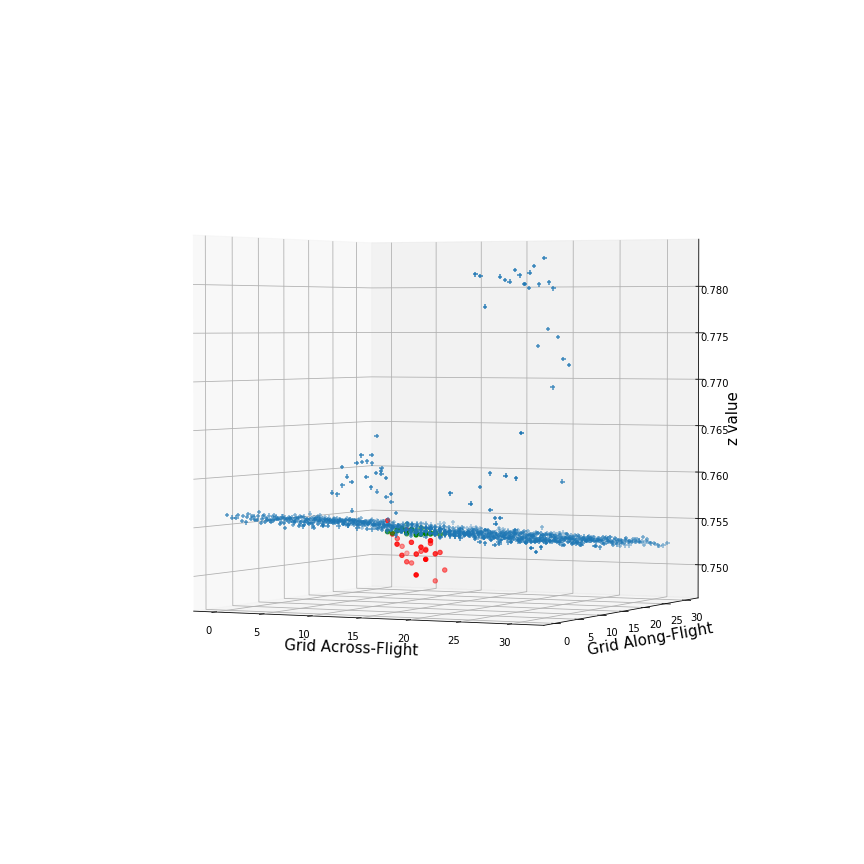

In [79]:
%matplotlib notebook
im_idx = 28

def plot_infill(clean,output,mask,label_key = 'z'):
    ''' Plotting function for 2D infill. Takes a single patch for clean,output, 
    and mask, and a label_key indicating which value (x,y, or z) to display.    
    '''
    # Which dimension to plot
    xyz_dict = {'x':2,'y':3,'z':4}
    z_val = xyz_dict[label_key]
    # Set up plot
    fig = plt.figure(figsize=[12,12])
    ax = fig.add_subplot(111, projection='3d')

    # Plot unmasked points
    surrounding_no_mask = mask[0] != 0
    unmasked_arr = np.array(lidar_data_processing.surrounding_grid(clean,surrounding_no_mask))
    ax.scatter(unmasked_arr[:,0],unmasked_arr[:,1],unmasked_arr[:,z_val], marker='+')

    # Plot masked, filled points
    surrounding_mask = mask[0] == 0
    filled_arr = np.array(lidar_data_processing.surrounding_grid(output,surrounding_mask))
    ax.scatter(filled_arr[:,0],filled_arr[:,1],filled_arr[:,z_val], color='r', marker='o')

    # Plot original, masked points
    masked_arr = np.array(lidar_data_processing.surrounding_grid(clean,surrounding_mask))
    ax.scatter(masked_arr[:,0],masked_arr[:,1],masked_arr[:,z_val], color='g', marker='o')

    # Labels and such
    ax.set_xlabel('Grid Across-Flight',fontsize=15)
    ax.set_ylabel('Grid Along-Flight',fontsize=15)
    ax.set_zlabel(label_key+' value',fontsize=15)

    plt.show()
#     print(output.shape)
#     print(clean.shape)
#     print(weighted_MSELoss(output.unsqueeze(0),clean[:,:3,:].unsqueeze(0),sc))
          
plot_infill(inputs[im_idx],outputs[im_idx],mask_inputs[im_idx],'z')

<IPython.core.display.Javascript object>


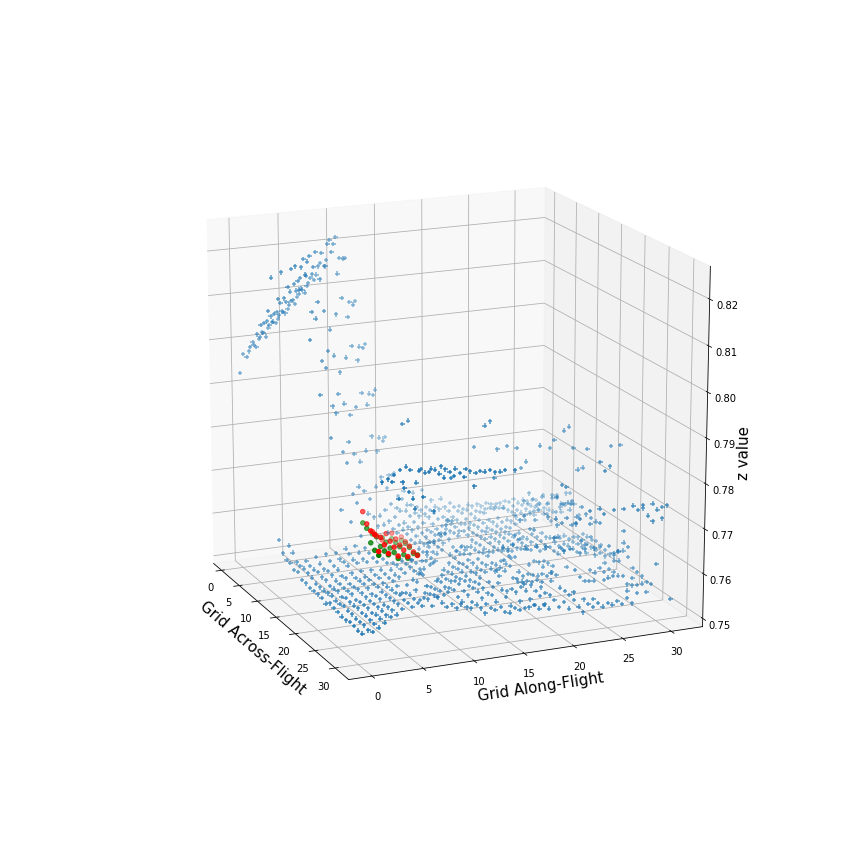

tensor(6.8198e+09, dtype=torch.float64)


/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([1, 3, 32, 32])) that is different to the input size (torch.Size([1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


In [69]:
plot_infill(inputs[im_idx],output_interp[im_idx],mask_inputs[im_idx],'z')

In [ ]:
import plotly
import plotly.graph_objs as go

In [ ]:
outputs.shape

In [ ]:
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=outputs.detach()[0,0,:,5],  # <-- Put your data instead
    y=outputs.detach()[0,1,:,5],  # <-- Put your data instead
    z=outputs.detach()[0,2,:,5],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)